In [1]:
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import Lasso
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression
import seaborn as sns

Here are defined usefull functions to convert prices to return and viceversa (like in matlab) and to calculate the transaction costs

In [2]:
def ret2price(ret):
    price = np.ones(len(ret))
    for i in range(1, len(ret)):
        price[i] = ret[i]*price[i-1]
    return price
def price2ret(price):
    ret = np.ones(len(price))
    for i in range(1, len(ret)):
        ret[i] = price[i]/price[i-1]
    return ret
def calculate_transaction_costs(change_in_positions, cost_per_trade):
    return np.sum(np.abs(change_in_positions)) * cost_per_trade

Here we load the dataset for the train/validation set (here they act basically as one since we deal with a rolling window).
On the file InvestmentReplica2 we have devided the dataset into two sheets, one for Train and the other for test.
Here we only import the train one, the test one will be used on an other notebook.
The idea here is to let the Lasso do all of the feature selection, so we don't remove any of the futures from the dataset.
Also we also create a monthly resemple of the dataset for later purposes...

In [3]:
# Load the dataset
data = pd.read_excel('InvestmentReplica2.xlsx', sheet_name='Replica')  

data.set_index('Date', inplace=True);
monthly_prices = data.resample('M').last()

# Define the target variable as a linear combination of 'HFRXGL', 'MXWO', and 'LEGATRUU'
data['Target'] = 0.25 * data['HFRXGL'] + 0.5 * data['MXWO'] + 0.25 * data['LEGATRUU']
monthly_prices['Target'] = 0.25 * monthly_prices['HFRXGL'] + 0.5 * monthly_prices['MXWO'] + 0.25 * monthly_prices['LEGATRUU']


# Compute returns for all columns
returns = data.pct_change()+1
returns = returns.fillna(0)

returns_monthly = monthly_prices.pct_change()+1
returns_monthly = returns_monthly.fillna(0)


# Define features (predictors) and target variable
features = returns.columns.drop(['HFRXGL', 'MXWO', 'LEGATRUU','MXWD','Target'])  # Exclude the target variable and other columns
target = 'Target'

features_monthly = returns_monthly.columns.drop(['HFRXGL', 'MXWO', 'LEGATRUU','MXWD','Target'])  # Exclude the target variable and other columns
target = 'Target'

X = returns[features].values  # Convert to numpy array
y = returns[target].values  # Convert to numpy array

X_month=returns_monthly[features].values
y_month=returns_monthly[target].values

Here we devise a 24 weeks rolling window to train our lasso model in order to find the optimal hyperparameter for the L1 penalty. The goal is to let Lasso regression handle the feature selection to optimally remove in each window the assets which seem to not relate too much  with the fund returns. This is is also in order to  avoid high commission fees

In [4]:
window_size = 24 #24 weeks = 6 month

# Lists to store actual and predicted prices
actual_return = []
predicted_return = []
# Create the rolling window regression model

alphas = np.logspace(-8, -5, num=10)

mse=[];

for alpha in alphas:
    for start in range(len(returns) - window_size):
        mse_cumulative=0;
        end = start + window_size
        X_train, X_test = X[start:end-1], X[end-1:end+1]
        y_train, y_test = y[start:end-1], y[end-1:end+1]

        # Initialize and fit the model
        model = Lasso(alpha=alpha,fit_intercept=False,tol=1e-4,max_iter=10000)
        model.fit(X_train, y_train)

        # Predict the next week
        y_pred = model.predict(X_test)

        # Store actual and predicted prices for plotting
        actual_return.append(y_test[1])
        predicted_return.append(y_pred[1])
        mse_cumulative+=(y_test[1]-y_pred[1])**2
        
        actual_price=ret2price(actual_return)
        predicted_price_monthly=ret2price(predicted_return)
    mse.append(mse_cumulative)

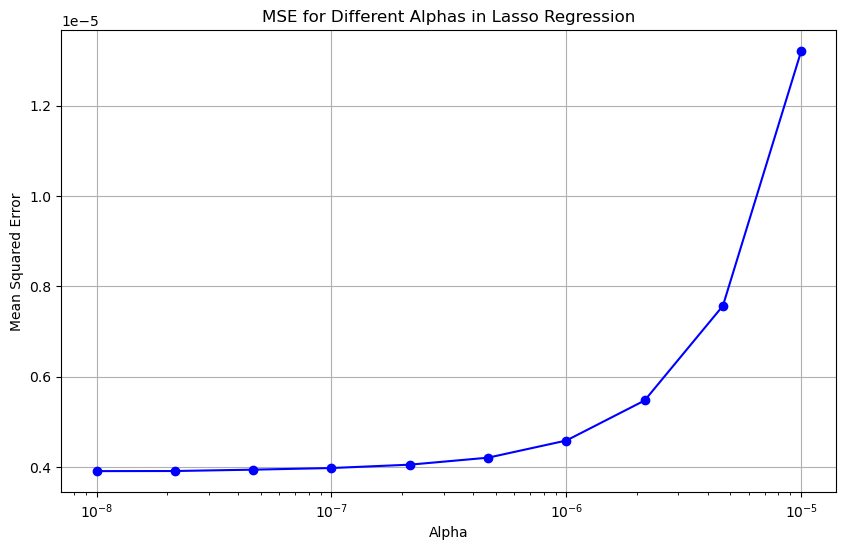

In [5]:
plt.figure(figsize=(10, 6))
plt.semilogx(alphas, mse, marker='o', linestyle='-', color='b')
plt.xlabel('Alpha')
plt.ylabel('Mean Squared Error')
plt.title('MSE for Different Alphas in Lasso Regression')
plt.grid(True)
plt.show()

On the validation set it seems that the optimal value for the alpha is actually really low, we pick 1e-8 to try on out test set. 
For the moment, here's the plot of the "In Sample" performance of our model.
Here we also plot the performance of our replicated portfolio having taken into account transaction costs.
The transaction costs here are modeled as a fixed bid ask spread which is multiplied by the absolute value in the change in position of our portfolio.
The bid ask spread was set to 0.0005 and was estimated taking an average of the bid ask spread for the period.

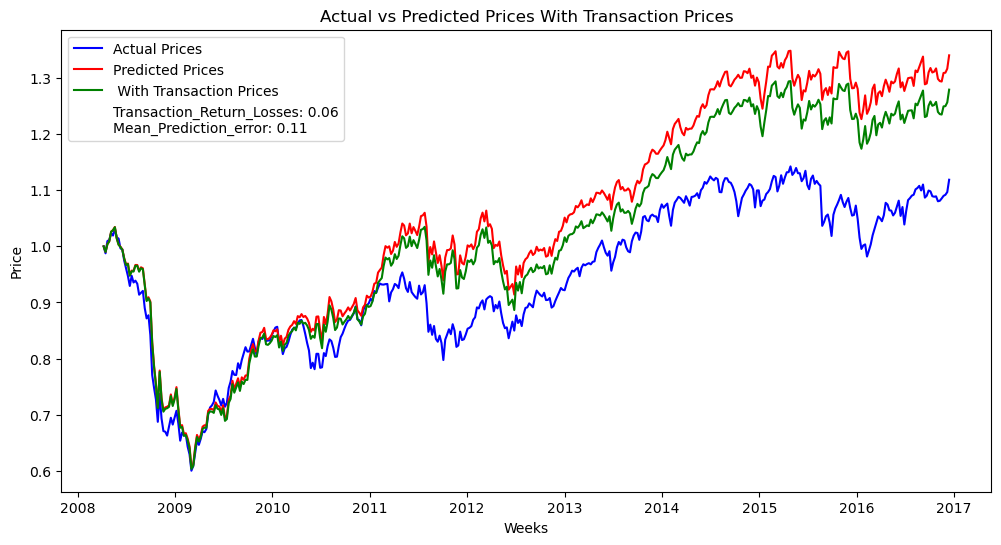

In [6]:
actual_return = []
predicted_return = []
portfolio_weights=[]
window_size = 24
for start in range(len(returns) - window_size):
    end = start + window_size
    X_train, X_test = X[start:end-1], X[end-1:end+1]
    y_train, y_test = y[start:end-1], y[end-1:end+1]

        # Initialize and fit the model
    model = Lasso(alpha=1e-8,fit_intercept=False,tol=1e-4,max_iter=100000)
    model.fit(X_train, y_train)

    portfolio_weights.append(model.coef_)
        # Predict the next week
    y_pred = model.predict(X_test)

        # Store actual and predicted prices for plotting
    actual_return.append(y_test[1])
    predicted_return.append(y_pred[1])        
    actual_price=ret2price(actual_return)
    predicted_price=ret2price(predicted_return)


    weight_changes = abs(np.diff(portfolio_weights, axis=0))
    cost_per_unit = 0.0005  # example cost
    adjusted_portfolio_prices = [actual_price[0]]
    for i in range(len(weight_changes)):
        transaction_cost = calculate_transaction_costs(weight_changes[i], cost_per_unit)
        # Adjust the portfolio price by subtracting the transaction costs
        adjusted_price = adjusted_portfolio_prices[-1] * (predicted_return[i+1]) - transaction_cost
        adjusted_portfolio_prices.append(adjusted_price)
#print(transaction_cost)
# Plot the actual vs predicted prices

Transaction_losses=predicted_price[-1]-adjusted_portfolio_prices[-1]


plt.figure(figsize=(12, 6))
plt.plot(data.index[24:],actual_price, label='Actual Prices', color='blue')
plt.plot(data.index[24:],predicted_price, label='Predicted Prices', color='red')
plt.plot(data.index[24:],adjusted_portfolio_prices, label=' With Transaction Prices', color='Green')

Mean_Prediction_error=np.mean(np.abs(predicted_price-actual_price))

extra_legend_labels = [
    f'Transaction_Return_Losses: {Transaction_losses:.2f}\n'
    f'Mean_Prediction_error: {Mean_Prediction_error:.2f}'
    ]
# Add dummy plots for the extra legend entries
plt.plot([], [], ' ', label=extra_legend_labels[0])



plt.title('Actual vs Predicted Prices With Transaction Prices')
plt.xlabel('Weeks')
plt.ylabel('Price')
plt.legend()
plt.show()

On the validations set the model seems to be tracking the target nicely at the start but later on diverges a little.

Our portfolio replica is doing better than the target, but since our goal is to track the benchmark and not beat it.

Another thing we note is that we are actually losing quite some of our return on transaction fees, which isn't optimal.

Also we see computed the  "mean_prediction_error" which is the mean of the distance between our portoflio replica prices and the actual realized index prices over the whole period.

We feel that if we allow our algorithms to rebalance the portfolio monthly (and not weekly) we may pay less transaction fees without loosing too much tracking ability.


In [7]:
#Versione Monthly
window_size = 12

# Lists to store actual and predicted prices
actual_return = []
predicted_return = []
# Create the rolling window regression model

alphas = np.logspace(-6, -4, num=10)

mse=[];

for alpha in alphas:
    for start in range(len(returns_monthly) - window_size):
        mse_cumulative=0;
        end = start + window_size
        X_train, X_test = X_month[start:end-1], X_month[end-1:end+1]
        y_train, y_test = y_month[start:end-1], y_month[end-1:end+1]

        # Initialize and fit the model
        model = Lasso(alpha=alpha,fit_intercept=False,tol=1e-4,max_iter=10000)
        model.fit(X_train, y_train)

        portfolio_weights.append(model.coef_)
        # Predict the next week
        y_pred = model.predict(X_test)

        # Store actual and predicted prices for plotting
        actual_return.append(y_test[1])
        predicted_return.append(y_pred[1])
        mse_cumulative+=(y_test[1]-y_pred[1])**2
        
        actual_price=ret2price(actual_return)
        predicted_price_monthly=ret2price(predicted_return)
    mse.append(mse_cumulative)

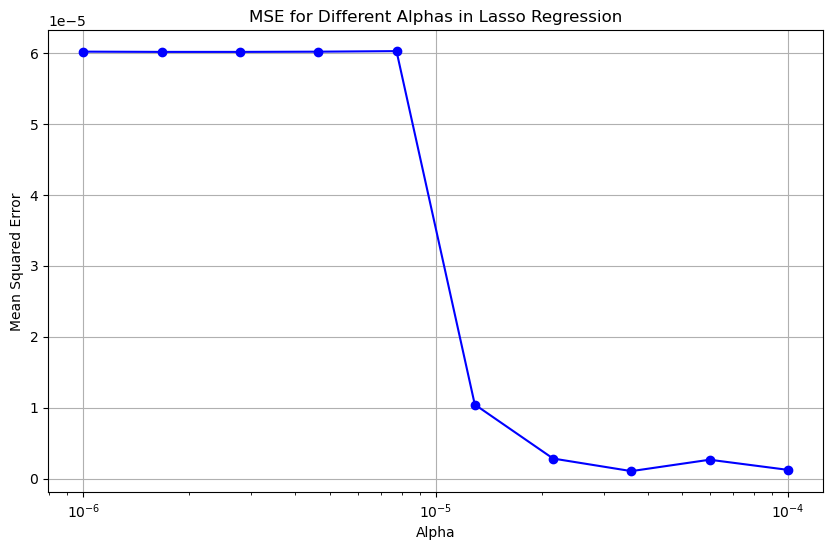

In [8]:
plt.figure(figsize=(10, 6))
plt.semilogx(alphas, mse, marker='o', linestyle='-', color='b')
plt.xlabel('Alpha')
plt.ylabel('Mean Squared Error')
plt.title('MSE for Different Alphas in Lasso Regression')
plt.grid(True)
plt.show()

Following the same principle as before, here we choose a 5*1e-5 alpha parameter.

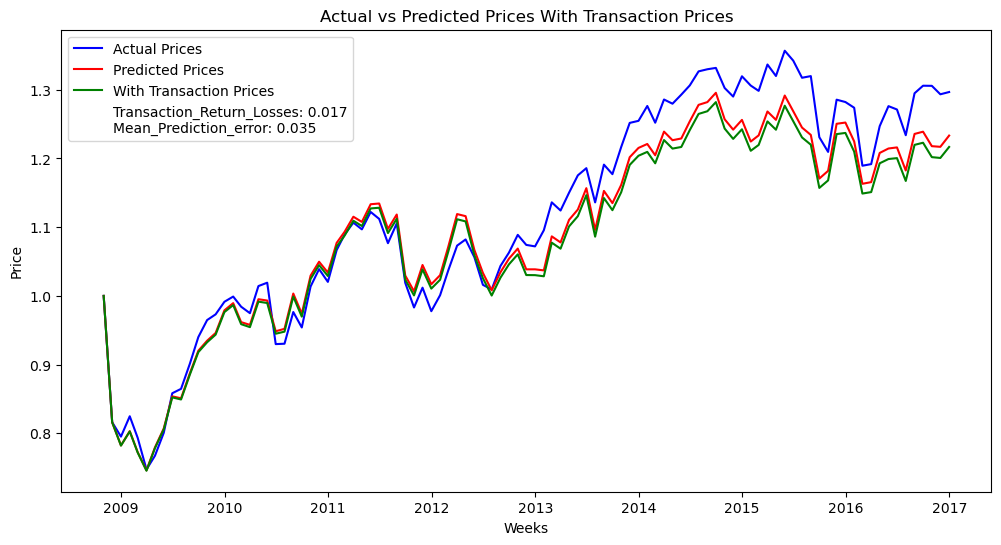

In [10]:
actual_return = []
predicted_return = []
portfolio_weights=[]
window_size = 12
for start in range(len(returns_monthly) - window_size):
    end = start + window_size
    X_train, X_test = X_month[start:end-1], X_month[end-1:end+1]
    y_train, y_test = y_month[start:end-1], y_month[end-1:end+1]
        # Initialize and fit the model
    model = Lasso(alpha=5*1e-5,fit_intercept=False,tol=1e-4,max_iter=100000)
    model.fit(X_train, y_train)

    portfolio_weights.append(model.coef_)
        # Predict the next week
    y_pred = model.predict(X_test)

        # Store actual and predicted prices for plotting
    actual_return.append(y_test[0])
    predicted_return.append(y_pred[0])        
    actual_price=ret2price(actual_return)
    predicted_price=ret2price(predicted_return)


    weight_changes = abs(np.diff(portfolio_weights, axis=0))
    cost_per_unit = 0.0005  # example cost
    adjusted_portfolio_prices = [actual_price[0]]
    for i in range(len(weight_changes)):
        transaction_cost = calculate_transaction_costs(weight_changes[i], cost_per_unit)
        # Adjust the portfolio price by subtracting the transaction costs
        adjusted_price = adjusted_portfolio_prices[-1] * (predicted_return[i+1]) - transaction_cost
        adjusted_portfolio_prices.append(adjusted_price)
#print(transaction_cost)
# Plot the actual vs predicted prices

plt.figure(figsize=(12, 6))
plt.plot(returns_monthly.index[12:],actual_price, label='Actual Prices', color='blue')
plt.plot(returns_monthly.index[12:],predicted_price, label='Predicted Prices', color='red')
plt.plot(returns_monthly.index[12:],adjusted_portfolio_prices, label='With Transaction Prices', color='Green')

Mean_Prediction_error=np.mean(np.abs(predicted_price-actual_price))
Transaction_losses=predicted_price[-1]-adjusted_portfolio_prices[-1]

extra_legend_labels = [
    f'Transaction_Return_Losses: {Transaction_losses:.3f}\n'
    f'Mean_Prediction_error: {Mean_Prediction_error:.3f}'
    ]
# Add dummy plots for the extra legend entries
plt.plot([], [], ' ', label=extra_legend_labels[0])

plt.title('Actual vs Predicted Prices With Transaction Prices')
plt.xlabel('Weeks')
plt.ylabel('Price')
plt.legend()
plt.show()

Using a monthly resample we've managed to get a way better tracking 0.03 mean preadiction error against 0.11 we obtained before. 

Also we  payed way less transaction fees as we should expect from a less frequent portfolio rebalancement. We decreased our transaction costs by a factor of 3 (from 0.06 to 0.02)

These are just the in sample performances. On the other Notebook the performances on the test set will be shown and commented.